In [1]:
import numpy as np

In [2]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-8):
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.epsilon = epsilon

    def forward(self, x):
        self.input = x  # 存储输入数据
        self.mu = np.mean(x, axis=0)
        self.var = np.var(x, axis=0)
        self.x_hat = (x - self.mu) / np.sqrt(self.var + self.epsilon)
        self.out = self.gamma * self.x_hat + self.beta
        return self.out

    def backward(self, grad_output, learning_rate):
        m = grad_output.shape[0]
        x_mu = self.input - self.mu
        std_inv = 1. / np.sqrt(self.var + self.epsilon)

        grad_x_hat = grad_output * self.gamma
        grad_var = np.sum(grad_x_hat * x_mu, axis=0) * -.5 * std_inv**3
        grad_mu = np.sum(grad_x_hat * -std_inv, axis=0) + grad_var * np.mean(-2. * x_mu, axis=0)

        grad_input = (grad_x_hat * std_inv) + (grad_var * 2 * x_mu / m) + (grad_mu / m)
        self.grad_gamma = np.sum(grad_output * self.x_hat, axis=0)
        self.grad_beta = np.sum(grad_output, axis=0)

        # Update gamma and beta
        self.gamma -= learning_rate * self.grad_gamma
        self.beta -= learning_rate * self.grad_beta

        return grad_input

## Adam优化器

In [3]:
class AdamOptimizer:
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, weights, gradients, learning_rate):
        if self.m is None:
            self.m = np.zeros_like(weights)
            self.v = np.zeros_like(weights)

        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradients
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradients ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        update_step = (learning_rate * m_hat) / (np.sqrt(v_hat) + self.epsilon)
        weights -= update_step

## Momentum优化器

In [4]:
class MomentumOptimizer:
    def __init__(self, momentum=0.9):
        self.momentum = momentum
        self.v = None

    def update(self, weights, gradients, learning_rate):
        if self.v is None:
            self.v = np.zeros_like(weights)

        self.v = self.momentum * self.v - learning_rate * gradients
        weights += self.v

## Adagrad优化器

In [5]:
class AdagradOptimizer:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon
        self.G = None

    def update(self, weights, gradients, learning_rate):
        if self.G is None:
            self.G = np.zeros_like(weights)

        self.G += gradients ** 2
        weights -= (learning_rate / (np.sqrt(self.G) + self.epsilon)) * gradients

## MLP回归器

In [6]:
class MLPRegressor:
    def __init__(self, input_size, hidden_sizes, output_size, activation='sigmoid', evaluation='mae', l1_penalty=0.9, l2_penalty=0.9, use_batch_norm=False):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_hidden_layers = len(hidden_sizes)
        self.activation = activation
        self.evaluation = evaluation

        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

        self.use_batch_norm = use_batch_norm
        self.batch_norm_layers = []

        # 初始化输入层的参数
        self.weights = [np.random.randn(input_size, hidden_sizes[0])]
        self.biases = [np.zeros((1, hidden_sizes[0]))]
        if self.use_batch_norm:
            self.batch_norm_layers.append(BatchNormalization(hidden_sizes[0]))

        # 初始化隐藏层的参数
        for i in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i + 1]))
            self.biases.append(np.zeros((1, hidden_sizes[i + 1])))
            if self.use_batch_norm:
                self.batch_norm_layers.append(BatchNormalization(hidden_sizes[i + 1]))

        self.weights.append(np.random.randn(hidden_sizes[-1], output_size))
        self.biases.append(np.zeros((1, output_size)))


    def forward(self, x):
        self.linear_outputs = []
        self.activation_outputs = []
        self.batch_norm_outputs = []
        activation_output = x

        for i in range(self.num_hidden_layers):
            linear_output = np.dot(activation_output, self.weights[i]) + self.biases[i]
            if self.use_batch_norm:
                batch_norm_output = self.batch_norm_layers[i].forward(linear_output)
                activation_output = self.activate(batch_norm_output)
                self.batch_norm_outputs.append(batch_norm_output)
            else:
                activation_output = self.activate(linear_output)
            self.activation_outputs.append(activation_output)
            self.linear_outputs.append(linear_output)

        linear_output = np.dot(activation_output, self.weights[-1]) + self.biases[-1]
        self.linear_outputs.append(linear_output)
        return linear_output

    def backward(self, x, y, output, learning_rate, penalty=None, optimizer='default'):
        linear_gradients = []
        d_output = 2 * (output - y) / len(x)
        linear_gradients.append(d_output)

        for i in range(self.num_hidden_layers, 0, -1):
            d_activation = np.dot(linear_gradients[-1], self.weights[i].T)
            if self.use_batch_norm:
                d_linear = d_activation * self.activation_derivative(self.batch_norm_outputs[i - 1])
                d_linear = self.batch_norm_layers[i - 1].backward(d_linear, learning_rate)
            else:
                d_linear = d_activation * self.activation_derivative(self.activation_outputs[i - 1])
            linear_gradients.append(d_linear)

        linear_gradients.reverse()

        for i in range(self.num_hidden_layers + 1):
            if i == 0:
                activation_output = x
            else:
                activation_output = self.activation_outputs[i - 1]

            d_weights = np.dot(activation_output.T, linear_gradients[i])
            d_biases = np.sum(linear_gradients[i], axis=0, keepdims=True)

            if penalty == 'l1':
                penalty_weights = np.where(self.weights[i] > 0, 1, -1) * self.l1_penalty
            elif penalty == 'l2':
                penalty_weights = 2 * self.l2_penalty * self.weights[i]
            elif penalty == 'elastic':
                l1_weights = np.where(self.weights[i] > 0, 1, -1) * self.l1_penalty
                l2_weights = 2 * self.l2_penalty * self.weights[i]
                penalty_weights = l1_weights + l2_weights
            else:
                penalty_weights = 0

            if optimizer == 'adam':
                adam_optimizer = AdamOptimizer()
                adam_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            elif optimizer == 'momentum':
                momentum_optimizer = MomentumOptimizer()
                momentum_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            elif optimizer == 'adagrad':
                adagrad_optimizer = AdagradOptimizer()
                adagrad_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            else:
                self.weights[i] -= learning_rate * (d_weights + penalty_weights)
                self.biases[i] -= learning_rate * d_biases



    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def activate(self, x):
        if self.activation == 'sigmoid':
            return self.sigmoid(x)
        elif self.activation == 'relu':
            return self.relu(x)
        elif self.activation == 'tanh':
            return self.tanh(x)
        else:
            raise ValueError('Invalid activation function.')
        
    def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.activation == 'relu':
            return self.relu_derivative(x)
        elif self.activation == 'tanh':
            return self.tanh_derivative(x)
        else:
            raise ValueError('Invalid activation function.')
    
    def mae(self, y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def rmse(self, y_true, y_pred):
        return np.sqrt(self.mse(y_true, y_pred))
    
    def evaluate(self, y_true, y_pred):
        if self.evaluation == 'mae':
            return self.mae(y_true, y_pred)
        elif self.evaluation == 'mse':
            return self.mse(y_true, y_pred)
        elif self.evaluation == 'rmse':
            return self.rmse(y_true, y_pred)
        else:
            raise ValueError('Invalid evaluation function.')

    def train(self, x_train, y_train, batch_size=32, learning_rate=0.001, epochs=1000, lr_decay=0.999, penalty=None, optimizer='default'):
        num_samples = len(x_train)
        for epoch in range(epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, num_samples, batch_size):
                x_batch = x_train_shuffled[i:i + batch_size]
                y_batch = y_train_shuffled[i:i + batch_size]

                output = self.forward(x_batch)
                loss = np.mean((output - y_batch) ** 2)
                self.backward(x_batch, y_batch, output, learning_rate, penalty, optimizer)

            if lr_decay is not None:
                learning_rate *= lr_decay

            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, x):
        return self.forward(x)

## 回归数据处理及训练

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 读取CSV文件
data = pd.read_csv('./datas/boston.csv')

# 提取特征和目标变量列
X = data.drop('MEDV', axis=1).values  # 特征列
y = data['MEDV'].values.reshape(-1, 1)  # 目标变量列

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

y_train_normalized = scaler.fit_transform(y_train)
y_test_normalized = scaler.transform(y_test)

# # 特征标准化
# X_train_mean = np.mean(X_train, axis=0)
# X_train_std = np.std(X_train, axis=0)
# X_train_normalized = (X_train - X_train_mean) / X_train_std
# X_test_normalized = (X_test - X_train_mean) / X_train_std  # 使用训练集的均值和标准差进行标准化

# # 目标变量标准化
# y_train_mean = np.mean(y_train)
# y_train_std = np.std(y_train)
# y_train_normalized = (y_train - y_train_mean) / y_train_std
# y_test_normalized = (y_test - y_train_mean) / y_train_std  # 使用训练集的均值和标准差进行标准化

# 实例化MLP回归器并训练模型
mlp_regressor = MLPRegressor(input_size=X_train_normalized.shape[1], hidden_sizes=[64, 32], output_size=1, activation='sigmoid', evaluation='mae')
mlp_regressor.train(X_train_normalized, y_train_normalized, penalty=None, batch_size=32, epochs=1000, learning_rate=0.01, optimizer='momentum')

# 使用训练好的模型进行测试并计算误差
y_pred = mlp_regressor.predict(X_test_normalized)
error = mlp_regressor.evaluate(y_test, scaler.inverse_transform(y_pred))

print(mlp_regressor.evaluation.upper(), ':', + error)

Epoch 0, Loss: 1.2136366472231157
Epoch 100, Loss: 0.1363472120244354
Epoch 200, Loss: 0.09116782411098394
Epoch 300, Loss: 0.19927310756319647
Epoch 400, Loss: 0.15310269531855142
Epoch 500, Loss: 0.10753669813545633
Epoch 600, Loss: 0.06842146156868108
Epoch 700, Loss: 0.12237995072006569
Epoch 800, Loss: 0.06504334558433582
Epoch 900, Loss: 0.04641407967706247
MAE : 2.9345126782167164


## pyTorch实现

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error

# 定义多层感知器模型
class TorchMLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(TorchMLPRegressor, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'relu':
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# 转换数据为 PyTorch 的 Tensor 格式
X_train_torch = torch.FloatTensor(X_train_normalized)
y_train_torch = torch.FloatTensor(y_train_normalized)
X_test_torch = torch.FloatTensor(X_test_normalized)

# 实例化模型并定义优化器和损失函数
input_size = X_train_torch.shape[1]
hidden_sizes = [64, 32]
output_size = 1
activation = 'sigmoid'
mlp_model = TorchMLPRegressor(input_size, hidden_sizes, output_size, activation)
criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01)

# 训练模型
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# 使用训练好的模型进行测试并计算误差
with torch.no_grad():
    mlp_model.eval()
    y_pred_torch = mlp_model(X_test_torch)
    y_pred = scaler.inverse_transform(y_pred_torch.numpy())
    error = mean_absolute_error(y_test, y_pred)

print(f'MAE: {error}')

Epoch [100/1000], Loss: 0.9610810279846191
Epoch [200/1000], Loss: 0.9214171767234802
Epoch [300/1000], Loss: 0.8641680479049683
Epoch [400/1000], Loss: 0.7829352617263794
Epoch [500/1000], Loss: 0.6806349158287048
Epoch [600/1000], Loss: 0.5762503147125244
Epoch [700/1000], Loss: 0.4920906722545624
Epoch [800/1000], Loss: 0.4318290054798126
Epoch [900/1000], Loss: 0.3862800598144531
Epoch [1000/1000], Loss: 0.3491266369819641
MAE: 3.3110910714841353


## MLP分类器

In [9]:
class MLPClassifier:
    def __init__(self, input_size, hidden_sizes, output_size, activation='sigmoid', evaluation='mae', l1_penalty=0.1, l2_penalty=0.1):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.num_hidden_layers = len(hidden_sizes)
        self.activation = activation
        self.evaluation = evaluation

        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty

        # 初始化输入层的参数
        self.weights = [np.random.randn(input_size, hidden_sizes[0])]
        self.biases = [np.zeros((1, hidden_sizes[0]))]

        # 初始化隐藏层的参数
        for i in range(self.num_hidden_layers - 1):
            self.weights.append(np.random.randn(hidden_sizes[i], hidden_sizes[i+1]))
            self.biases.append(np.zeros((1, hidden_sizes[i+1])))

        self.weights.append(np.random.randn(hidden_sizes[-1], output_size))
        self.biases.append(np.zeros((1, output_size)))

    def forward(self, x):
        self.linear_outputs = []
        self.activation_outputs = []
        activation_output = x
        for i in range(self.num_hidden_layers):
            linear_output = np.dot(activation_output, self.weights[i]) + self.biases[i]
            activation_output = self.activate(linear_output)
            self.activation_outputs.append(activation_output)
            self.linear_outputs.append(linear_output)

        linear_output = np.dot(activation_output, self.weights[self.num_hidden_layers]) + self.biases[self.num_hidden_layers]
        activation_output = self.softmax(linear_output)
        self.activation_outputs.append(activation_output)
        self.linear_outputs.append(linear_output)

        return activation_output

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x)**2

    def activate(self, x):
        if self.activation == 'sigmoid':
            return self.sigmoid(x)
        elif self.activation == 'relu':
            return self.relu(x)
        elif self.activation == 'tanh':
            return self.tanh(x)
        else:
            raise ValueError('Invalid activation function.')
        
    def activation_derivative(self, x):
        if self.activation == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.activation == 'relu':
            return self.relu_derivative(x)
        elif self.activation == 'tanh':
            return self.tanh_derivative(x)
        else:
            raise ValueError('Invalid activation function.')
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def backward(self, x, y, output, learning_rate, penalty=None, optimizer='default'):
        linear_gradients = []

        d_output = output - y
        linear_gradients.append(d_output)

        for i in range(self.num_hidden_layers, 0, -1):
            # Calculate the gradient for the current layer's output
            d_activation = np.dot(linear_gradients[-1], self.weights[i].T)
            a = self.activation_derivative(self.activation_outputs[i-1])
            d_linear = d_activation * a
            linear_gradients.append(d_linear)

        linear_gradients.reverse()

        for i in range(self.num_hidden_layers + 1):
            if i == 0:
                activation_output = x
            else:
                activation_output = self.activation_outputs[i-1]

            # Calculate the weight and bias gradients
            d_weights = np.dot(activation_output.T, linear_gradients[i])
            d_biases = np.sum(linear_gradients[i], axis=0, keepdims=True)

            # Update weights and biases with regularization penalties
            if penalty == 'l1':
                penalty_weights = np.where(self.weights[i] > 0, 1, -1) * self.l1_penalty
            elif penalty == 'l2':
                penalty_weights = 2 * self.l2_penalty * self.weights[i]
            elif penalty == 'elastic':
                l1_weights = np.where(self.weights[i] > 0, 1, -1) * self.l1_penalty
                l2_weights = 2 * self.l2_penalty * self.weights[i]
                penalty_weights = l1_weights + l2_weights
            else:
                penalty_weights = 0

            # Update weights and biases using the selected optimizer
            if optimizer == 'adam':
                adam_optimizer = AdamOptimizer()
                adam_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            elif optimizer == 'momentum':
                momentum_optimizer = MomentumOptimizer()
                momentum_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            elif optimizer == 'adagrad':
                adagrad_optimizer = AdagradOptimizer()
                adagrad_optimizer.update(self.weights[i], d_weights + penalty_weights, learning_rate)
            else:
                self.weights[i] -= learning_rate * (d_weights + penalty_weights)
                self.biases[i] -= learning_rate * d_biases

    def accuracy(self, y_true, y_pred):
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true_class = np.argmax(y_true, axis=1)
        return np.mean(y_pred_class == y_true_class)

    def evaluate(self, y_true, y_pred):
        if self.evaluation == 'accuracy':
            return self.accuracy(y_true, y_pred)
        else:
            raise ValueError('Invalid evaluation function.')

    def train(self, x_train, y_train, batch_size=32, learning_rate=0.001, epochs=1000, lr_decay=0.999, penalty=None, optimizer='default'):
        num_samples = len(x_train)
        for epoch in range(epochs):
            # Shuffle the training data for each epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            x_train_shuffled = x_train[indices]
            y_train_shuffled = y_train[indices]

            for i in range(0, num_samples, batch_size):
                x_batch = x_train_shuffled[i:i+batch_size]
                y_batch = y_train_shuffled[i:i+batch_size]

                output = self.forward(x_batch)
                loss = self.evaluate(y_batch, output)
                self.backward(x_batch, y_batch, output, learning_rate, penalty, optimizer)

            if lr_decay is not None:
                learning_rate *= lr_decay

            print(f'Epoch {epoch}, Accuracy: {loss}')

    def predict(self, x):
        return self.forward(x)

## 数据处理及训练

In [10]:
from sklearn.preprocessing import OneHotEncoder

# 读取CSV文件
train_data = pd.read_csv('./datas/mnist_train.csv')
test_data = pd.read_csv('./datas/mnist_test.csv')

X_train = train_data.iloc[:, 1:].values / 255.0
y_train = train_data.iloc[:, 0].values.reshape(-1, 1)

X_test = test_data.iloc[:, 1:].values / 255.0
y_test = test_data.iloc[:, 0].values.reshape(-1, 1)

encoder = OneHotEncoder(categories='auto')
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded.toarray(), test_size=0.2, random_state=42)

input_size = 28*28
hidden_sizes = [64]
output_size = 10
mlp_classifier = MLPClassifier(input_size, hidden_sizes, output_size, activation='sigmoid', evaluation='accuracy')
mlp_classifier.train(X_train, y_train_encoded, batch_size=32, learning_rate=0.01, epochs=10, penalty='l1', optimizer='momentum')

# Evaluate the model on the validation set
val_accuracy = mlp_classifier.evaluate(y_val_encoded, mlp_classifier.predict(X_val))
print(f'Validation Accuracy: {val_accuracy}')

# Evaluate the model on the test set
test_accuracy = mlp_classifier.evaluate(y_test_encoded.toarray(), mlp_classifier.predict(X_test))
print(f'Test Accuracy: {test_accuracy}')

Epoch 0, Accuracy: 0.78125
Epoch 1, Accuracy: 0.8125
Epoch 2, Accuracy: 0.78125
Epoch 3, Accuracy: 0.78125
Epoch 4, Accuracy: 0.875
Epoch 5, Accuracy: 0.78125
Epoch 6, Accuracy: 0.71875
Epoch 7, Accuracy: 0.875
Epoch 8, Accuracy: 0.90625
Epoch 9, Accuracy: 0.75
Validation Accuracy: 0.8575
Test Accuracy: 0.8712


## 混淆矩阵

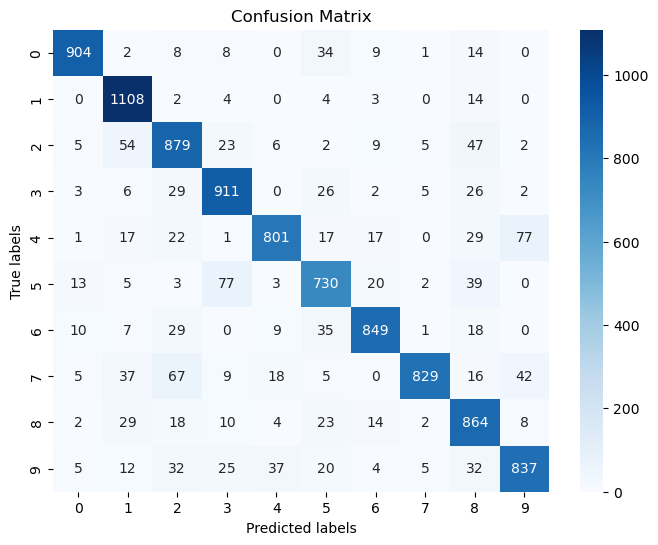

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
def compute_confusion_matrix(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_class = np.argmax(y_pred, axis=1)
    y_true_class = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_true_class, y_pred_class)
    return cm

# 在训练完成后调用该函数并绘制混淆矩阵热图
conf_matrix = compute_confusion_matrix(mlp_classifier, X_test, y_test_encoded.toarray())

# 使用Seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## AUC及ROC

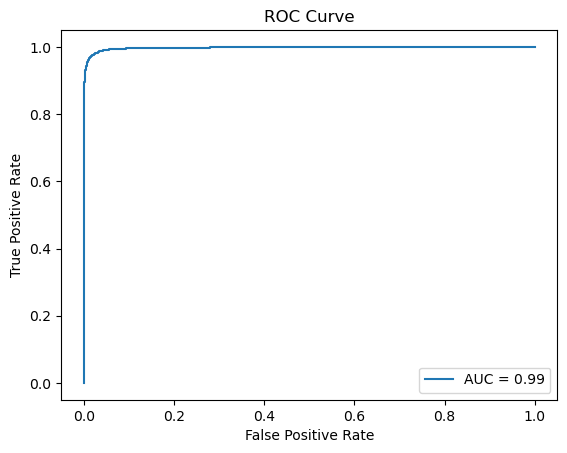

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 在训练完成后，使用该函数计算ROC曲线和AUC
def compute_roc_auc(model, x_test, y_test):
    y_pred = model.predict(x_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_pred[:, 1])  # 假正率、真正率、阈值
    auc = roc_auc_score(y_test, y_pred)
    return fpr, tpr, auc

# 在训练完成后调用该函数并绘制ROC曲线
fpr, tpr, auc = compute_roc_auc(mlp_classifier, X_test, y_test_encoded.toarray())
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

## pyTorch实现MLP分类器

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

# 定义多层感知器模型
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation):
        super(MLPClassifier, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            if activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'relu':
                layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# 转换数据为 PyTorch 的 Tensor 格式
X_train_torch = torch.FloatTensor(X_train)
y_train_torch = torch.LongTensor(y_train_encoded)
X_val_torch = torch.FloatTensor(X_val)
y_val_torch = torch.LongTensor(y_val_encoded)
X_test_torch = torch.FloatTensor(X_test)
y_test_torch = torch.LongTensor(y_test_encoded.toarray())

# 实例化模型并定义优化器和损失函数
input_size = X_train_torch.shape[1]
hidden_sizes = [128, 64]
output_size = 10
activation = 'sigmoid'
mlp_model = MLPClassifier(input_size, hidden_sizes, output_size, activation)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp_model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
epochs = 10
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mlp_model(X_train_torch)
    loss = criterion(outputs, torch.max(y_train_torch, 1)[1])  # 由于使用了 OneHot 编码，需要使用 argmax 获取类别
    loss.backward()
    optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')

# 使用训练好的模型进行评估
with torch.no_grad():
    mlp_model.eval()
    y_pred_val = mlp_model(X_val_torch)
    # 将模型输出转换为整数格式
    y_pred_int = torch.argmax(y_pred_val, dim=1).numpy()  # 模型输出转换为整数格式
    y_val_int = torch.argmax(y_val_torch, dim=1).numpy()  # 目标数据转换为整数格式
    val_accuracy = accuracy_score(y_val_int, y_pred_int)
    y_pred_test = mlp_model(X_test_torch)
    y_pred_int = torch.argmax(y_pred_test, dim=1).numpy()
    y_test_int = torch.argmax(y_test_torch, dim=1).numpy()
    test_accuracy = accuracy_score(y_test_int, y_pred_int)

print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Epoch [1/10], Loss: 2.335369348526001
Epoch [2/10], Loss: 2.334167242050171
Epoch [3/10], Loss: 2.331973075866699
Epoch [4/10], Loss: 2.3290395736694336
Epoch [5/10], Loss: 2.325631618499756
Epoch [6/10], Loss: 2.322002410888672
Epoch [7/10], Loss: 2.3183746337890625
Epoch [8/10], Loss: 2.3149290084838867
Epoch [9/10], Loss: 2.311800718307495
Epoch [10/10], Loss: 2.3090782165527344
Validation Accuracy: 0.0995
Test Accuracy: 0.1009
